In [7]:
import numpy as np 
import os
from tensorflow.keras.models import *
import tensorflow.keras.losses
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import tensorflow as tf
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
from sklearn.metrics import mean_squared_error
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours

# functions to find border mask for angle mute boundaries
def find_border_mask(arr):
    # Create a mask for the non-zero areas
    non_zero_mask = arr != 0
    # Use binary dilation to find the border
    border_mask = non_zero_mask & ~binary_dilation(~non_zero_mask)

    return border_mask

def find_border_points(mask):
    contours = find_contours(mask, 0.5)
    border_points = []
    for contour in contours:
        for point in contour:
            border_points.append(tuple(reversed(point.astype(int))))
    return border_points

In [8]:
# load trained model for 10-20-30 near-mid-far and print its summary
model = tf.keras.models.load_model('unet-resnet-102030.h5', compile=True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1248, 3)]    0           []                               
                                                                                                  
 conv1d_48 (Conv1D)             (None, 1248, 16)     160         ['input_3[0][0]']                
                                                                                                  
 activation_20 (Activation)     (None, 1248, 16)     0           ['conv1d_48[0][0]']              
                                                                                                  
 conv1d_49 (Conv1D)             (None, 1248, 16)     784         ['activation_20[0][0]']          
                                                                                            

                                                                  'activation_27[0][0]']          
                                                                                                  
 conv1d_63 (Conv1D)             (None, 156, 128)     49280       ['concatenate_8[0][0]']          
                                                                                                  
 conv1d_64 (Conv1D)             (None, 156, 128)     16512       ['conv1d_63[0][0]']              
                                                                                                  
 up_sampling1d_9 (UpSampling1D)  (None, 312, 128)    0           ['conv1d_64[0][0]']              
                                                                                                  
 concatenate_9 (Concatenate)    (None, 312, 192)     0           ['up_sampling1d_9[0][0]',        
                                                                  'activation_25[0][0]']          
          

In [16]:
# time and offset limits to crop gathers
up = 143
low = 1391
nt = low-up
off_lim = 130

In [17]:
num = 1

# load data sample corresponding to num (full gathers, near mid far angle gathers)
inp = np.load('./synthetics/input_full/inp_'+str(num)+'.npy')
inp = inp[up:low, :off_lim]

targ = np.load('./synthetics/target_full/targ_'+str(num)+'.npy')
targ = targ[up:low, :off_lim]

inp_near = np.load('./synthetics/input_near/inp_near_'+str(num)+'.npy')
inp_near = inp_near[up:low, :off_lim]
targ_near = np.load('./synthetics/target_near/targ_near_'+str(num)+'.npy')
targ_near = targ_near[up:low, :off_lim]
inp_mid = np.load('./synthetics/input_mid/inp_mid_'+str(num)+'.npy')
inp_mid = inp_mid[up:low, :off_lim]
targ_mid = np.load('./synthetics/target_mid/targ_mid_'+str(num)+'.npy')
targ_mid = targ_mid[up:low, :off_lim]
inp_far = np.load('./synthetics/input_far/inp_far_'+str(num)+'.npy')
inp_far = inp_far[up:low, :off_lim]
targ_far = np.load('./synthetics/target_far/targ_far_'+str(num)+'.npy')
targ_far = targ_far[up:low, :off_lim]

# generate mask for angle mute boundary plot
mask_mid = find_border_mask(inp_mid)
mask_far = find_border_mask(inp_far)
mask_points_mid = find_border_points(mask_mid)
mask_points_far = find_border_points(mask_far)
mask_points = mask_points_mid 
mask_points_x = [i[0] for i in mask_points]
mask_points_y = [i[1] for i in mask_points]
true_indices = np.argmax(mask_far, axis=1)
mask_far_for_zero = np.copy(mask_far)
for i in range(mask_far_for_zero.shape[0]):
    mask_far_for_zero[i, :true_indices[i]] = True
    
inp_mod = np.copy(inp)
inp_mod[mask_far_for_zero == False] = 0
targ_mod = np.copy(targ)
targ_mod[mask_far_for_zero == False] = 0


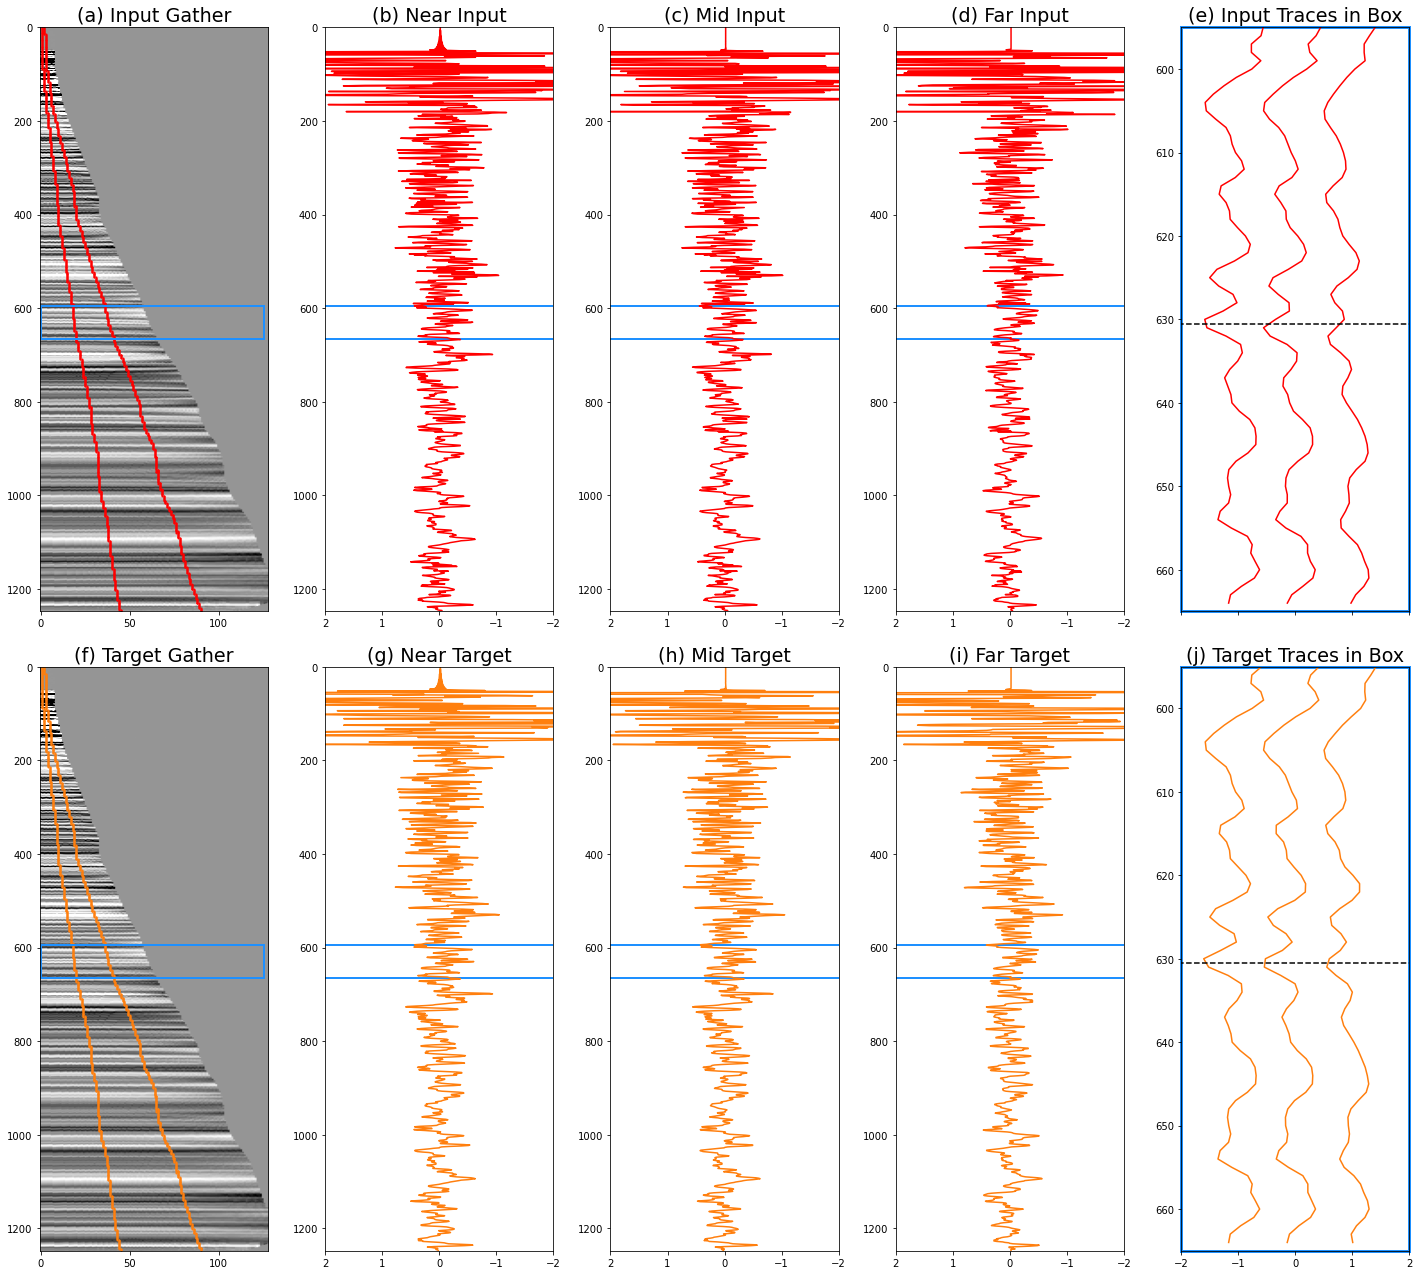

In [29]:
stacks = np.zeros((6,low-up))
data = [inp_near, inp_mid, inp_far, targ_near, targ_mid, targ_far]
for d,i in zip(data, range(6)):        
    stacks[i,:] = np.sum(d, axis=1) / np.count_nonzero(d, axis=1)
stacks = np.nan_to_num(stacks, nan=0.0)
stacks = (stacks - stacks.mean()) / stacks.std()
inp_trip = np.stack((stacks[0,:], stacks[1,:], stacks[2,:]), axis=1)
targ_trip = np.stack((stacks[3,:], stacks[4,:], stacks[5,:]), axis=1)

nt_plot = 1248
cmin = -2e-2
cmax = 2e-2
xlim = -2
xlim2 = 2
vertical_spacing = 1

%matplotlib inline
fig,ax = plt.subplots(2, 5, figsize=(20,18))
plt.rcParams.update({'font.size': 16})

refl_min = 595
refl_max = 665
refl_line = 630.5

im = ax[0,0].imshow(inp_mod[:nt_plot,:], aspect='auto', cmap='Greys', vmin=cmin, vmax=cmax)
ax[0,0].set_title('(a) Input Gather')
ax[0,0].scatter(mask_points_x, mask_points_y, s=0.9, color='red')
ax[0,0].set_ylim(nt_plot,0)
box = patches.Rectangle((0.5,refl_min), 125, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[0,0].add_patch(box)

ax[0,1].plot(inp_trip[:nt_plot, 0], range(nt_plot), color='red')
ax[0,1].set_ylim(0,nt_plot)
ax[0,1].set_xlim(-xlim,xlim)
ax[0,1].set_title('(b) Near Input')
ax[0,1].invert_yaxis()
box1 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[0,1].add_patch(box1)

ax[0,2].plot(inp_trip[:nt_plot, 1], range(nt_plot), color='red')
ax[0,2].set_ylim(0,nt_plot)
ax[0,2].set_xlim(-xlim,xlim)
ax[0,2].set_title('(c) Mid Input')
ax[0,2].invert_yaxis()
box2 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[0,2].add_patch(box2)

ax[0,3].plot(inp_trip[:nt_plot, 2], range(nt_plot), color='red')
ax[0,3].set_ylim(0,nt_plot)
ax[0,3].set_xlim(-xlim,xlim)
ax[0,3].set_title('(d) Far Input')
ax[0,3].invert_yaxis()
box3 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[0,3].add_patch(box3)

ax[0,4].plot(inp_trip[refl_min:refl_max, 0]-vertical_spacing, range(refl_min,refl_max), color='red')
ax[0,4].plot(inp_trip[refl_min:refl_max, 1], range(refl_min,refl_max), color='red')
ax[0,4].plot(inp_trip[refl_min:refl_max, 2]+vertical_spacing, range(refl_min,refl_max), color='red')
ax[0,4].set_ylim(refl_min,refl_max)
ax[0,4].set_xlim(-xlim2,xlim2)
ax[0,4].set_title('(e) Input Traces in Box')
ax[0,4].hlines(refl_line, -10, 10, color='black', ls='--')
ax[0,4].invert_yaxis()
ax[0,4].patch.set_edgecolor('dodgerblue')  
ax[0,4].patch.set_linewidth('3')  
ax[0,4].set_xticklabels([]);

########################################

ax[1,0].imshow(targ_mod[:nt_plot,:], aspect='auto', cmap='Greys', vmin=cmin, vmax=cmax)
ax[1,0].set_title('(f) Target Gather')
ax[1,0].scatter(mask_points_x, mask_points_y, s=0.9, color='#ff7f0e')
ax[1,0].set_ylim(nt_plot,0)
box4 = patches.Rectangle((0.5,refl_min), 125, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[1,0].add_patch(box4)

ax[1,1].plot(targ_trip[:nt_plot, 0], range(nt_plot), color='#ff7f0e')
ax[1,1].set_ylim(0,nt_plot)
ax[1,1].set_xlim(-xlim,xlim)
ax[1,1].set_title('(g) Near Target')
ax[1,1].invert_yaxis()
box5 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[1,1].add_patch(box5)

ax[1,2].plot(targ_trip[:nt_plot, 1], range(nt_plot), color='#ff7f0e')
ax[1,2].set_ylim(0,nt_plot)
ax[1,2].set_xlim(-xlim,xlim)
ax[1,2].set_title('(h) Mid Target')
ax[1,2].invert_yaxis()
box6 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[1,2].add_patch(box6)

ax[1,3].plot(targ_trip[:nt_plot, 2], range(nt_plot), color='#ff7f0e')
ax[1,3].set_ylim(0,nt_plot)
ax[1,3].set_xlim(-xlim,xlim)
ax[1,3].set_title('(i) Far Target')
ax[1,3].invert_yaxis()
box7 = patches.Rectangle((-5,refl_min), 10, refl_max-refl_min, linewidth=2, edgecolor='dodgerblue', facecolor='none')
ax[1,3].add_patch(box7)

ax[1,4].plot(targ_trip[refl_min:refl_max, 0]-vertical_spacing, range(refl_min,refl_max), color='#ff7f0e')
ax[1,4].plot(targ_trip[refl_min:refl_max, 1], range(refl_min,refl_max), color='#ff7f0e')
ax[1,4].plot(targ_trip[refl_min:refl_max, 2]+vertical_spacing, range(refl_min,refl_max), color='#ff7f0e')
ax[1,4].set_ylim(refl_min,refl_max)
ax[1,4].set_xlim(-xlim2,xlim2)
ax[1,4].set_title('(j) Target Traces in Box')
ax[1,4].hlines(refl_line, -10, 10, color='black', ls='--')
ax[1,4].invert_yaxis()
ax[1,4].patch.set_edgecolor('dodgerblue')  
ax[1,4].patch.set_linewidth('3') 

plt.tight_layout()

In [30]:
# reshape input angle stacks for prediction
before = np.reshape(inp_trip, (1, nt_plot, 3))   

# use trained model to predict
pred = model.predict(before)
pred = pred[0,:,:]

1/1 [==============================] - 0s 21ms/step


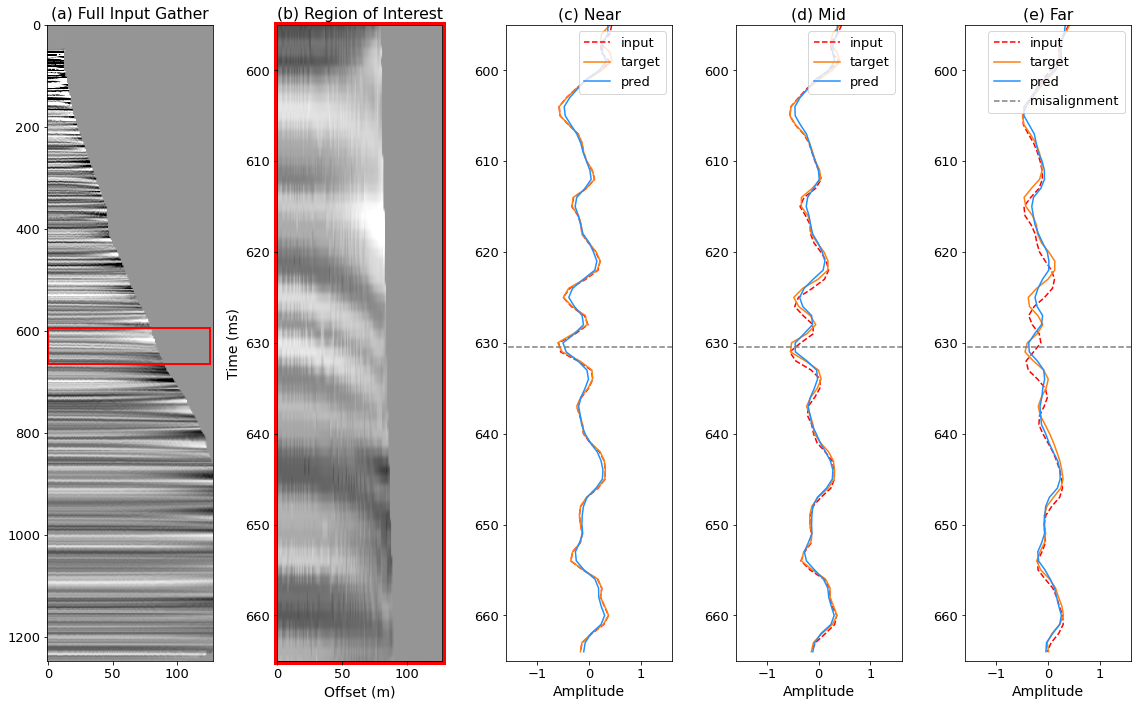

In [33]:
%matplotlib inline
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(1, 5,figsize=(16,10))

sz = 14
cmin = -0.03
cmax = 0.03
xlimit = 1.6

im = ax[0].imshow(inp, aspect='auto', cmap='Greys', vmin=cmin, vmax=cmax)
ax[0].set_title('(a) Full Input Gather')
box = patches.Rectangle((0.5,refl_min), 125, refl_max-refl_min, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(box)

ax[1].imshow(inp, aspect='auto', cmap='Greys', vmin=cmin, vmax=cmax)
ax[1].set_title('(b) Region of Interest')
ax[1].set_xlabel('Offset (m)', fontsize=sz)
ax[1].set_ylabel('Time (ms)', fontsize=sz)
ax[1].set_ylim(refl_max, refl_min)
ax[1].patch.set_edgecolor('red')  
ax[1].patch.set_linewidth('7')  

ax[2].plot(inp_trip[refl_min:refl_max, 0], range(refl_min,refl_max), 'r--', label='input')
ax[2].plot(targ_trip[refl_min:refl_max, 0], range(refl_min,refl_max), label='target', color='#ff7f0e')
ax[2].plot(pred[refl_min:refl_max, 0], range(refl_min,refl_max), label='pred', color='dodgerblue')
ax[2].hlines(refl_line, -10, 10, color='grey', ls='--')
ax[2].invert_yaxis()
ax[2].set_title('(c) Near')
ax[2].legend(loc='upper right')
ax[2].set_xlabel('Amplitude', fontsize=sz)
ax[2].set_xlim(-xlimit, xlimit)
ax[2].set_ylim(refl_max, refl_min)

ax[3].plot(inp_trip[refl_min:refl_max, 1], range(refl_min,refl_max), 'r--', label='input')
ax[3].plot(targ_trip[refl_min:refl_max, 1], range(refl_min,refl_max), label='target', color='#ff7f0e')
ax[3].plot(pred[refl_min:refl_max, 1], range(refl_min,refl_max), label='pred', color='dodgerblue')
ax[3].hlines(refl_line, -10, 10, color='grey', ls='--')
ax[3].invert_yaxis()
ax[3].set_title('(d) Mid')
ax[3].legend(loc='upper right')
ax[3].set_xlabel('Amplitude', fontsize=sz)
ax[3].set_xlim(-xlimit, xlimit)
ax[3].set_ylim(refl_max, refl_min)

ax[4].plot(inp_trip[refl_min:refl_max, 2], range(refl_min,refl_max), 'r--', label='input')
ax[4].plot(targ_trip[refl_min:refl_max, 2], range(refl_min,refl_max), label='target', color='#ff7f0e')
ax[4].plot(pred[refl_min:refl_max, 2], range(refl_min,refl_max), label='pred', color='dodgerblue')
ax[4].hlines(refl_line, -10, 10, color='grey', ls='--', label='misalignment')
ax[4].invert_yaxis()
ax[4].set_title('(e) Far')
ax[4].legend(loc='upper right')
ax[4].set_xlabel('Amplitude', fontsize=sz)
ax[4].set_xlim(-xlimit, xlimit)
ax[4].set_ylim(refl_max, refl_min)

plt.tight_layout()